<a href="https://colab.research.google.com/github/Atadele1/INST414_Medium_4_Code/blob/main/INST414_Module_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
# mount drive
drive.mount('/content/drive', force_remount=True)

# change directory
os.chdir("/content/drive/MyDrive/INST414_Module4")


Mounted at /content/drive


Data loaded successfully!
Missing values in cluster data:
followers          0
influence_score    0
dtype: int64
Filled missing values in followers with mean: 77.4095
Filled missing values in influence_score with mean: 81.82
All missing values have been handled successfully!
Data prepared for clustering!
Tested 1 clusters
Tested 2 clusters
Tested 3 clusters
Tested 4 clusters
Tested 5 clusters
Tested 6 clusters
Tested 7 clusters
Tested 8 clusters
Tested 9 clusters
Tested 10 clusters


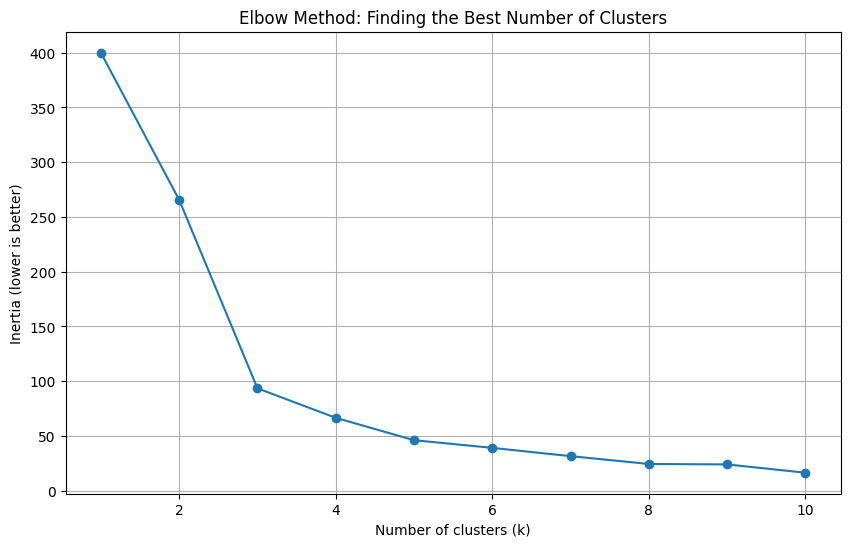

We'll use 3 clusters based on the elbow plot
         followers              country
              mean count       <lambda>
cluster                                
0         55.58655   171        Unknown
1         42.85000     8        Unknown
2        268.27619    21  United States


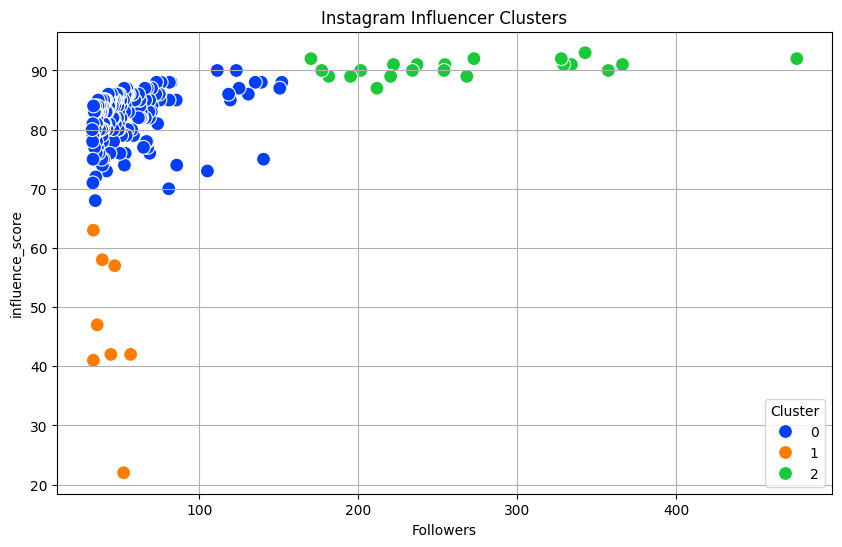

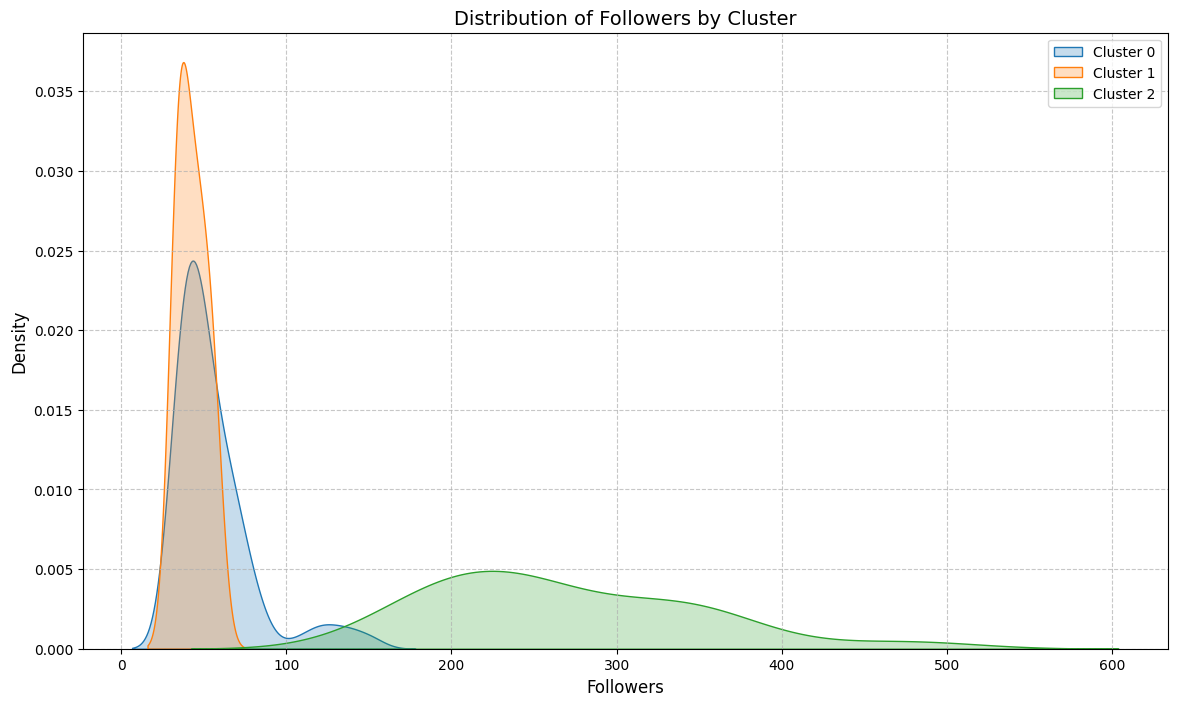

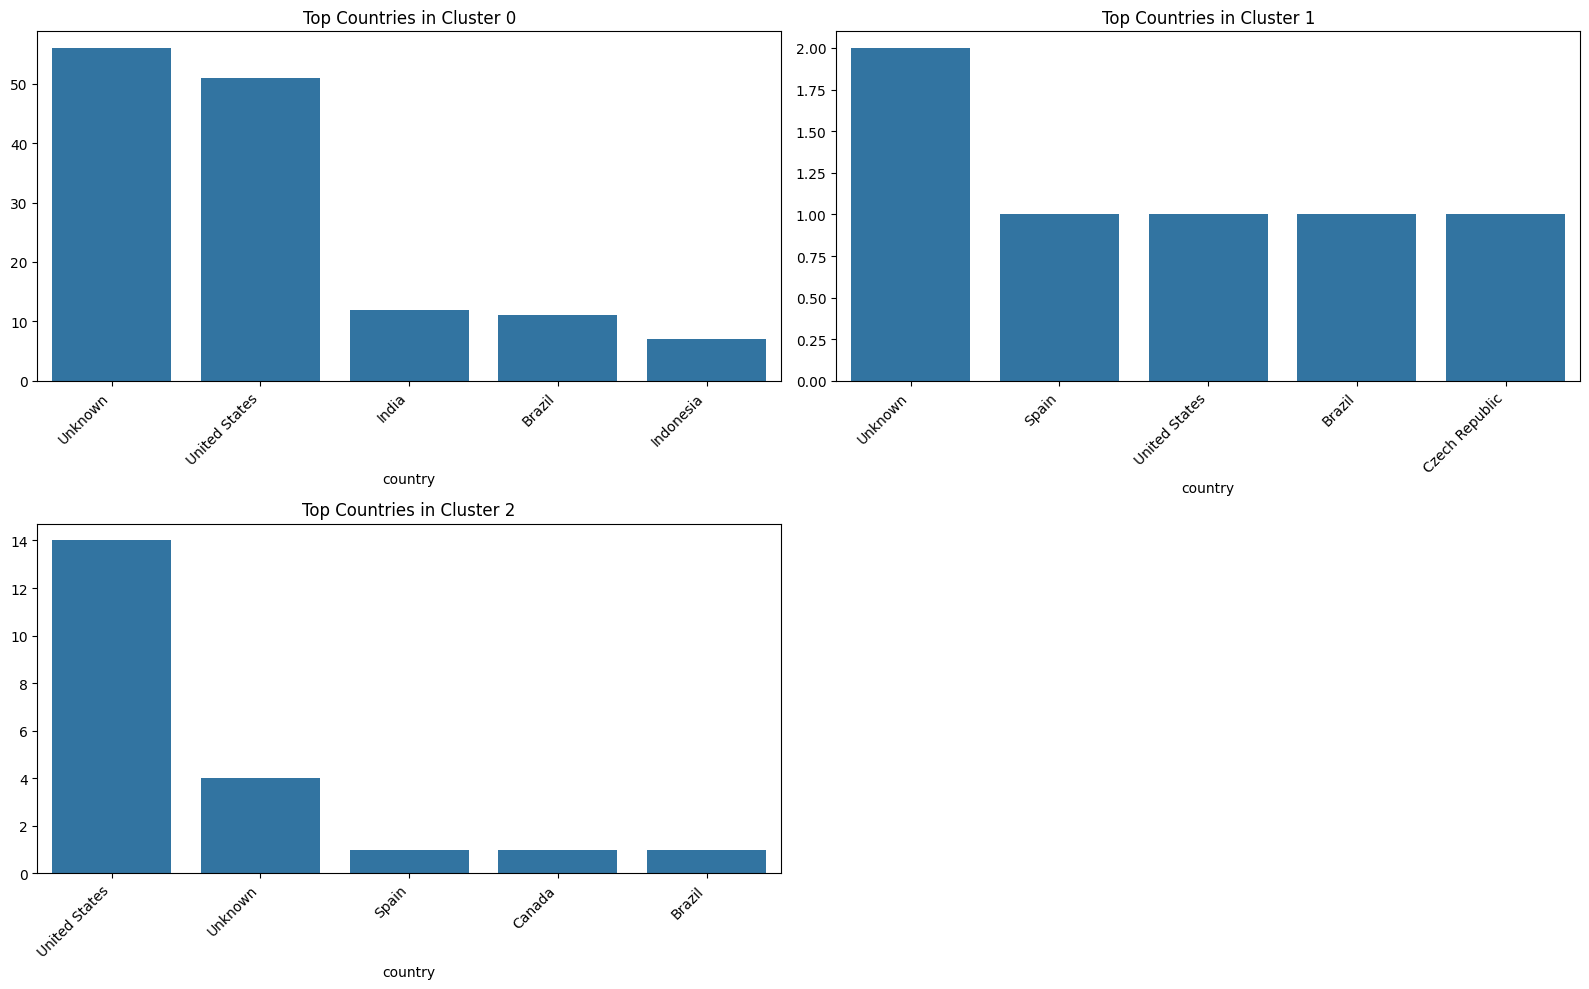


Cluster 0:
      channel_info  followers        country
21  kevinhart4real      152.0  United States
22         zendaya      150.7  United States
23       iamcardib      140.5  United States

Cluster 1:
     channel_info  followers        country
76   karimbenzema       56.9          Spain
93        mosalah       52.5        Unknown
114   harrystyles       46.9  United States

Cluster 2:
  channel_info  followers        country
0    cristiano      475.8          Spain
1  kyliejenner      366.2  United States
2     leomessi      357.3        Unknown


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the data
df = pd.read_csv("top_insta_influencers_data.csv")
print("Data loaded successfully!")

# Step 2: Clean the data
def clean_data(df):
    # Make a copy of the data
    clean_df = df.copy()

    # Convert followers (K, M, B) to numbers
    clean_df['followers'] = clean_df['followers'].astype(str)
    clean_df['followers'] = clean_df['followers'].str.replace('K', '000')
    clean_df['followers'] = clean_df['followers'].str.replace('M', '000000')
    clean_df['followers'] = clean_df['followers'].str.replace('B', '000000000')

    # Remove any non-numeric characters
    clean_df['followers'] = clean_df['followers'].str.replace(r'[^0-9.]', '', regex=True)

    # Convert to numbers
    clean_df['followers'] = pd.to_numeric(clean_df['followers'], errors='coerce')

    # Fill missing countries
    clean_df['country'] = clean_df['country'].fillna('Unknown')

    return clean_df

cleaned_df = clean_data(df)

# Step 3: Select features for clustering
features = ['followers']
if 'influence_score' in cleaned_df.columns:
    features.append('influence_score')


# Step 4: Prepare data for clustering
# Create a dataset with just our selected features
cluster_data = cleaned_df[features].copy()

# Check for missing values
print(f"Missing values in cluster data:\n{cluster_data.isnull().sum()}")

# Handle missing values by replacing with average
for column in cluster_data.columns:
    column_mean = cluster_data[column].mean()
    cluster_data[column] = cluster_data[column].fillna(column_mean)
    print(f"Filled missing values in {column} with mean: {column_mean}")

# Double-check that all NaN values are gone
if cluster_data.isnull().sum().sum() > 0:
    print("Warning: Still have missing values after filling!")
else:
    print("All missing values have been handled successfully!")

# Standardize the data (make all features on same scale)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)
print("Data prepared for clustering!")

# Step 5: Find the best number of clusters (k)
# Try different numbers of clusters and see which works best
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    print(f"Tested {k} clusters")

# Plot to choose the best k
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (lower is better)')
plt.title('Elbow Method: Finding the Best Number of Clusters')
plt.grid(True)
plt.savefig('elbow_method.png')
plt.show()

# Step 6: Choosing  the best k
optimal_k = 3
print(f"We'll use {optimal_k} clusters based on the elbow plot")

# Step 7: Perform clustering with our chosen k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cleaned_df['cluster'] = kmeans.fit_predict(scaled_data)

# Step 8: Analyze the clusters
# Calculate statistics for each cluster
cluster_summary = cleaned_df.groupby('cluster').agg({
    'followers': ['mean', 'count'],
    'country': lambda x: x.value_counts().index[0]  # Most common country
})

print(cluster_summary)

# Step 9: Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='followers',
    y=features[1] if len(features) > 1 else 'cluster',
    hue='cluster',
    palette='bright',
    data=cleaned_df,
    s=100
)
plt.title('Instagram Influencer Clusters')
plt.xlabel('Followers')
plt.ylabel(features[1] if len(features) > 1 else 'Cluster')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig('clusters.png')
plt.show()

# follower distribution by cluster
plt.figure(figsize=(14, 8))
for i in range(optimal_k):
    sns.kdeplot(
        cleaned_df[cleaned_df['cluster'] == i]['followers'],
        label=f'Cluster {i}',
        fill=True
    )
plt.title('Distribution of Followers by Cluster', fontsize=14)
plt.xlabel('Followers', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('follower_distribution.png')
plt.show()

# country distribution in each cluster
plt.figure(figsize=(16, 10))
for i in range(optimal_k):
    cluster_data = cleaned_df[cleaned_df['cluster'] == i]
    country_counts = cluster_data['country'].value_counts().head(5)

    plt.subplot(2, 2, i+1)
    sns.barplot(x=country_counts.index, y=country_counts.values)
    plt.title(f'Top Countries in Cluster {i}', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.savefig('country_distribution.png')
plt.show()

# Step 10: Show examples from each cluster
for i in range(optimal_k):
    print(f"\nCluster {i}:")
    # Show 3 examples from this cluster
    examples = cleaned_df[cleaned_df['cluster'] == i].head(3)
    print(examples[['channel_info', 'followers', 'country']])

# Save results
cleaned_df.to_csv('influencers_with_clusters.csv', index=False)


